# Part 1: Building an Item-Item Recommender

If you use Netflix, you will notice that there is a section titled "Because you watched Movie X", which provides recommendations for movies based on a recent movie that you've watched. This is a classic example of an item-item recommendation. 

In this tutorial, we will generate item-item recommendations using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering). Let's get started! 

## Step 1: Import the Dependencies

We will be representing our data as a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). 

**What is a DataFrame?**

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table
- documentation can be found here

We will also be using two plotting packages: [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/) (which is a wrapper of matplotlib) to visualize our data.

In [327]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning) # 在畫圖那邊的參數會有警告訊息

## Step 2: Load the Data

Let's download a small version of the [MovieLens](https://www.wikiwand.com/en/MovieLens) dataset. You can access it via the zip file url [here](https://grouplens.org/datasets/movielens/), or directly download [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip). We're working with data in `ml-latest-small.zip` and will need to add the following files to our local directory: 
- ratings.csv
- movies.csv

These are also located in the data folder inside this GitHub repository. 


Alternatively, you can access the data here (以下兩個連結已經無法使用，所以要先將檔案下載至本機後再讀取檔案。):  
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

Let's load in our data and take a peek at the structure.

In [328]:
ratings = pd.read_csv("./data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [329]:
movies = pd.read_csv("./data/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Step 3: Exploratory Data Analysis

In Part 1 of this tutorial series, we will focus on the `ratings` dataset. We'll need `movies` for subsequent sections. `Ratings` contains users' ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset. 

In [330]:
n_ratings = len(ratings)
n_movies = ratings["movieId"].nunique()
n_users = ratings["userId"].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Numer of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per users: {round(n_ratings / n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings / n_movies, 2)}")

Number of ratings: 100836
Numer of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per users: 165.3
Average number of ratings per movie: 10.37


In [331]:
print("電影總數是:", movies["movieId"].nunique())
print(movies["movieId"].unique()[:50]) # 可以看得出來電影的 ID 不是連續的
print("使用者總數是:", ratings["userId"].nunique())
print(ratings["userId"].unique()[:50]) # 使用者 ID 是連續的

電影總數是: 9742
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 36 38 39 40 41 42 43 44 45 46 47 48 49 50 52
 53 54]
使用者總數是: 610
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


Now, let's take a look at users' rating counts. We can do this using pandas' `groupby()` and `count()` which groups the data by `userId`'s and counts the number of ratings for each userId. 

In [332]:
user_freq = ratings[["userId", "movieId"]].groupby("userId").count().reset_index()
user_freq.columns = ["userId", "n_ratings"]
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [333]:
print(f"Mean number of ratings for a given user: {user_freq["n_ratings"].mean():.2f}.")

Mean number of ratings for a given user: 165.30.


On average, a user will have rated ~165 movies. Looks like we have some avid movie watchers in our dataset.

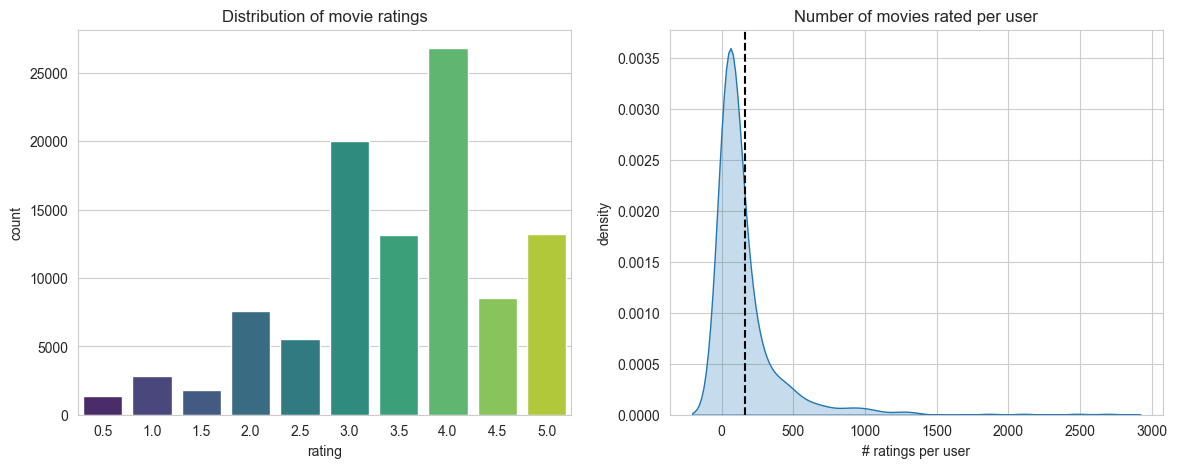

In [334]:
sns.set_style("whitegrid")
plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
ax = sns.countplot(data = ratings, x = "rating", palette = "viridis") # countplot：是一種 bar chart，統計某欄位的每個類別數量
plt.title("Distribution of movie ratings")

plt.subplot(1, 2, 2)
# 畫出 KDE (Kernel Density Estimation)（核密度估計）圖，表示「使用者平均評分幾部電影」的分布情形
# 也可以 sns.kdeplot(user_freq["n_ratings"], shade = True, legend = False)
ax = sns.kdeplot(user_freq, x = "n_ratings", shade = True, legend = False) # shade = True：圖形會填色
plt.axvline(user_freq["n_ratings"].mean(), color = "k", linestyle = "--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")

plt.show()

The most common rating is 4.0, while lower ratings such as 0.5 or 1.0 are much more rare. 

In [335]:
user_freq["n_ratings"].value_counts().reset_index()

,n_ratings,count
0,21,15
1,22,14
2,20,14
3,56,14
4,26,13
...,...,...
256,943,1
257,221,1
258,1115,1
259,831,1


可以看得出來，評分 20 多部電影的人居多

### Which movie has the lowest and highest average rating?

In [336]:
mean_rating = ratings.groupby("movieId")[["rating"]].mean()
lowest_rated = mean_rating["rating"].idxmin()
# lowest_rated # np.int64(3604)

display(movies[movies["movieId"] == lowest_rated])
# 其實評分為0.5的有很多部
mean_rating.sort_values(by = ["rating", "movieId"], ascending = [True, True])\
    .reset_index()

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


,movieId,rating
0,3604,0.5
1,3933,0.5
2,4051,0.5
3,4371,0.5
4,4580,0.5
...,...,...
9719,176601,5.0
9720,179133,5.0
9721,179135,5.0
9722,184245,5.0


In [337]:
movies[movies["title"].str.contains("Santa")] # 這裡其實也只是好奇作者在講什麼 XD

,movieId,title,genres
276,317,"Santa Clause, The (1994)",Comedy|Drama|Fantasy
1799,2399,Santa Claus: The Movie (1985),Adventure|Children|Fantasy
3421,4658,Santa Sangre (1989),Drama|Horror|Mystery|Thriller
4072,5804,"Santa Clause 2, The (2002)",Children|Comedy|Fantasy|Romance
4216,6119,Santa Claus Is a Stinker (Le Père Noël est une...,Comedy
4656,6957,Bad Santa (2003),Comedy|Crime
6339,49013,"Santa Clause 3: The Escape Clause, The (2006)",Comedy|Fantasy
8328,107449,"Muppet Christmas: Letters to Santa, A (2008)",Children|Comedy
8818,131098,Saving Santa (2013),Animation|Children|Comedy
9233,152658,Santa's Little Helper (2015),Children


Santa with Muscles is the worst rated movie!

In [338]:
highest_rated = mean_rating["rating"].idxmax()
movies[movies["movieId"] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [339]:
# 5.0 的一樣很多部
mean_rating.sort_values(by = ["rating", "movieId"], ascending = [False, True])\
    .reset_index()\
    .head()

,movieId,rating
0,53,5.0
1,99,5.0
2,148,5.0
3,467,5.0
4,495,5.0


Lamerica may be the "highest" rated movie, but how many ratings does it have?

In [340]:
ratings[ratings["movieId"] == highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Lamerica has only 2 ratings. A better approach for evaluating movie popularity is to look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average
貝葉斯平均值是透過外部資訊來衡量母體的平均值，這在資料集很小的時候很有用，為了防止資料過少而導致結果很極端。  
可以想像增加 C 個資料至分母以及 C 個數值為 m 的資料至分子，如此便能加權平均原本的結果。

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$  
如果資料集的變異程度很大，C 應該要小一點，反之則大。

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior will be the average rating across all movies. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given movie.

In [341]:
movie_stats = ratings.groupby("movieId")[["rating"]].agg(["count", "mean"])
movie_stats.columns = movie_stats.columns.droplevel()
movie_stats

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
...,...,...
193581,1,4.000000
193583,1,3.500000
193585,1,3.500000


In [342]:
C = movie_stats["count"].mean()
m = movie_stats["mean"].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby("movieId")["rating"].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ["movieId", "bayesian_avg"]
# bayesian_avg_ratings
movie_stats = movie_stats.merge(bayesian_avg_ratings, on = "movieId")
movie_stats

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.890632
1,2,110,3.431818,3.417227
2,3,52,3.259615,3.260086
3,4,7,2.357143,2.897612
4,5,49,3.071429,3.104793
...,...,...,...,...
9719,193581,1,4.000000,3.327318
9720,193583,1,3.500000,3.283341
9721,193585,1,3.500000,3.283341
9722,193587,1,3.500000,3.283341


In [343]:
movie_stats = movie_stats.merge(movies[["movieId", "title"]])
movie_stats.sort_values(by = "bayesian_avg", ascending = False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


Using the Bayesian average, we see that `Shawshank Redemption`, `The Godfather`, and `Fight Club` are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films.

Now which movies are the worst rated, according to the Bayesian average?

In [344]:
movie_stats.sort_values(by = "bayesian_avg", ascending = True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like `Speed 2: Cruise Control`, `Battlefield Earth`, and `Godzilla` are the worst rated movies. `Gypsy` isn't so bad after all!

In [345]:
# 這裡只是好奇使用者講的電影 bayesian_avg 是多少 XD
movie_stats[movie_stats["title"].str.contains("Gypsy")]

,movieId,count,mean,bayesian_avg,title
2685,3604,1,0.5,3.019485,Gypsy (1962)


## Step 4: Transforming the data

We will be using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations. 


<img src="images/user-movie-matrix.png" width="500px" align="left">

The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

以下的做法是因為 utility matrix 會從 0 開始，而 user ID 和 movie ID 是從 1 開始，所以才要這樣做。  
We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

csr_matrix 參數的順序跟上方的圖不一樣，列為電影數是為了要做 item-item，反之則是 user-user
<img src="images/csr_matrix.png" width="95%">

In [346]:
from scipy.sparse import csr_matrix # Compressed Sparse Row

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df["userId"].nunique()
    M = df["movieId"].nunique()

    user_mapper = dict(zip(df["userId"].unique(), list(range(N)))) # 1 ~ 610 maps 0 ~ 609
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), df["userId"].unique()))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df["userId"]] # 每位使用者的 index，可能會重複多筆 (對多個電影的評論)
    movie_index = [movie_mapper[i] for i in df["movieId"]] # 每部電影的 index，在 utility matrix 中，由上而下一直變動，直到換另一位使用者評論

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape = (M, N))
    # 上一行程式碼如同以下迴圈
    # for idx in range(len(df)):
        # row = movie_index[idx]
        # col = user_index[idx]
        # val = df["rating"].iloc[idx]
        # X[row, col] = val

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [347]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below:   
以下公式原作者似乎加上 # ，所以有出錯

$$S=\frac{\text{non-zero elements}}{\text{total elements}}$$

In [348]:
X # CSR 矩陣物件可以看出一些數據

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100836 stored elements and shape (9724, 610)>

In [349]:
round(100836 / (9724 * 610), 4)

0.017

In [350]:
sparsity = X.count_nonzero() / (X.shape[0] * X.shape[1])
print(f"Matrix sparsity: {round(sparsity * 100, 2)}%")

Matrix sparsity: 1.7%


Only 1.7% of cells in our user-item matrix are populated with ratings. But don't be discouraged by this sparsity! User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

### Writing your matrix to a file

We're going to save our user-item matrix for the next part of this tutorial series. Since our matrix is represented as a scipy sparse matrix, we can use the [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) method to write the matrix to a file. 

In [351]:
from scipy.sparse import save_npz # numpy 陣列檔打包起來的 zip 檔

save_npz("./data/user_item_matrix.npz", X) # or utility matrix

In [352]:
# 下次使用
from scipy.sparse import load_npz

X = load_npz("./data/user_item_matrix.npz")
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100836 stored elements and shape (9724, 610)>

<img src="images/knn.png" width="20%" align="right"/>

## Step 5: Finding similar movies using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix. 

在分類任務中，KNN 是屬於監督式學習，而在推薦系統中是非監督式學習，我們會透過像是 Cosine similarity 推出相似的電影

In [353]:
print(X[0]) # 用 print 可以預覽一些 CSR 的資料

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 215 stored elements and shape (1, 610)>
  Coords	Values
  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (0, 559)	3.0
  (0, 560)	4.0
  (0, 561)	4.5
  (0, 566)	3.5
  (0, 569)	4.0
  (0, 571)	4.0
  (0, 572)	5.0
  (0, 578)	4.0
  (0, 579)	3.0
  (0, 583)	5.0
  (0, 586)	5.0
  (0, 589)	4.0
  (0, 595)	4.0
  (0, 596)	4.0
  (0, 598)	3.0
  (0, 599)	2.5
  (0, 600)	4.0
  (0, 602)	4.0
  (0, 603)	3.0
  (0, 604)	4.0
  (0, 605)	2.5
  (0, 606)	4.0
  (0, 607)	2.5
  (0, 608)	3.0
  (0, 609)	5.0


In [354]:
print(type(X))
print(type(X[0]))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [355]:
from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import KNeighborsClassifier

def find_similar_movies(movie_id, X, k, metric = "cosine", show_distance = False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k += 1 # 自己跟自己會最像，所以要先加進來，後面會再移除
    KNN = NearestNeighbors(n_neighbors = k, algorithm = "brute", metric = metric) # brute 每一對都算距離，適合高維資料
    KNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)): # 如果是 np 類別的話
        movie_vec = movie_vec.reshape(1, -1) # 確保輸入是 2D 的，csr 則不用改，本身就是 (1, n) 的形狀
    neighbour = KNN.kneighbors(movie_vec, return_distance = show_distance) # 結果是 2D array
    for i in range(k):
        n = neighbour.item(i) # item(0) 就是 [0][0]
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [356]:
# movie_id = 1
# find_similar_movies(movie_id, X, k = 10, show_distance = True)[1].item(0) # 如果顯示距離的話，會回傳 tuple 包起來的兩個 array

`find_similar_movies()` takes in a movieId and user-item X matrix, and outputs a list of $k$ movies that are similar to the movieId of interest. 

Let's see how it works in action. We will first create another mapper that maps `movieId` to `title` so that our results are interpretable. 

In [357]:
movie_titles = dict(zip(movies["movieId"], movies["title"]))
# movie_titles
movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k = 10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


The results above show the 10 most similar movies to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not taken into consideration in this approach.  

In [358]:
max_bayesian_avg_index = movie_stats["bayesian_avg"].idxmax()
min_bayesian_avg_index = movie_stats["bayesian_avg"].idxmin()

display(movie_stats.iloc[max_bayesian_avg_index].to_frame().T) # 最大貝葉斯平均
movie_stats.iloc[min_bayesian_avg_index].to_frame().T # 最小貝葉斯平均

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.39207,"Shawshank Redemption, The (1994)"


,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)


You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [359]:
movie_titles = dict(zip(movies["movieId"], movies["title"]))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k = 10, metric = "euclidean")

movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)


In [360]:
display(movie_stats[movie_stats["movieId"] == movie_id])
for similar_id in similar_ids:
    # print(similar_id)
    display(movie_stats[movie_stats["movieId"] == similar_id])
# 顯示結果後才想到，這個推薦不是看貝葉斯平均，而是各個使用者的評分

,movieId,count,mean,bayesian_avg,title
0,1,215,3.92093,3.890632,Toy Story (1995)


,movieId,count,mean,bayesian_avg,title
2353,3114,97,3.860825,3.803033,Toy Story 2 (1999)


,movieId,count,mean,bayesian_avg,title
546,648,162,3.537037,3.520518,Mission: Impossible (1996)


,movieId,count,mean,bayesian_avg,title
615,780,202,3.445545,3.436604,Independence Day (a.k.a. ID4) (1996)


,movieId,count,mean,bayesian_avg,title
1756,2355,92,3.516304,3.490589,"Bug's Life, A (1998)"


,movieId,count,mean,bayesian_avg,title
622,788,82,2.731707,2.79129,"Nutty Professor, The (1996)"


,movieId,count,mean,bayesian_avg,title
815,1073,119,3.87395,3.824934,Willy Wonka & the Chocolate Factory (1971)


,movieId,count,mean,bayesian_avg,title
32,34,128,3.652344,3.623124,Babe (1995)


,movieId,count,mean,bayesian_avg,title
963,1265,143,3.944056,3.89797,Groundhog Day (1993)


,movieId,count,mean,bayesian_avg,title
325,367,157,3.184713,3.18953,"Mask, The (1994)"


,movieId,count,mean,bayesian_avg,title
1521,2054,68,2.757353,2.824187,"Honey, I Shrunk the Kids (1989)"


## Extra：User-based 在這個資料集的應用

In [361]:
from sklearn.neighbors import NearestNeighbors

def find_similar_users(user_id, X, k, metric = "cosine", show_distance = False):
    """
    Finds k-nearest neighbours for a given user id.
    
    Args:
        user_id: id of the user of interest
        X: user-item utility matrix
        k: number of similar users to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar user ID's
    """

    user_row = X[user_mapper[user_id]].toarray().flatten() # 取出使用者的評分，並轉成 1D
    zero_indices = np.where(user_row == 0)[0] # 找出值為 0 的 index，這代表使用者沒看過的電影

    neighbour_indices = []
    user_ind = user_mapper[user_id]
    user_vec = X[user_ind]
    k += 1 # 自己跟自己會最像，所以要先加進來，後面會再移除
    KNN = NearestNeighbors(n_neighbors = k, algorithm = "brute", metric = metric) # brute 每一對都算距離，適合高維資料
    KNN.fit(X)
    if isinstance(user_vec, (np.ndarray)): # 如果是 np 類別的話
        user_vec = user_vec.reshape(1, -1) # 確保輸入是 2D 的，csr 則不用改，本身就是 (1, n) 的形狀
    neighbour = KNN.kneighbors(user_vec, return_distance = show_distance) # 結果是 2D array
    for i in range(k):
        n = neighbour.item(i) # item(0) 就是 [0][0]
        neighbour_indices.append(n) # 這裡不是用 user_inv_mapper[n]，因為後續需要取出 utility matrix 的 rows，要用 indices
    neighbour_indices.pop(0)
    return neighbour_indices, zero_indices

X_user = X.T

In [362]:
# 會有這個程式碼是想再確認 movieId 是有跳號的，相對不直覺

user_id = 1
uidx = user_mapper[user_id] # userId = 1 對應到的 row index（別直接用 0，雖然 userId 沒有跳號，但還是有差 1，要保險一點）
cols = X_user[uidx].nonzero()[1] # 該使用者評過的「欄索引」

mids = [movie_inv_mapper[c] for c in cols]  # 轉回原始 movieId
# mids
print(50 in mids)   # 應該 True
print(44 in mids)   # 應該 False

True
False


In [363]:
similar_user_indices, zero_indices = find_similar_users(1, X_user, k = 10)
print(similar_user_indices) # 10 位與使用者最相似的使用者 ID
print(zero_indices)

[265, 312, 367, 56, 90, 468, 38, 287, 451, 44]
[   1    3    4 ... 9721 9722 9723]


In [364]:
target_user_have_not_seen = X_user[similar_user_indices, :][:, zero_indices]
target_user_have_not_seen # 最後的欄 index 是 9491，要透過 zero_indices[index] 來取得 movie_column_index

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 3264 stored elements and shape (10, 9492)>

In [365]:
number_of_nonzero_per_movie = np.asarray(target_user_have_not_seen.getnnz(axis = 0)).ravel() # getnnz()：取得非零元素的數量
sum_of_ratings_per_movie = np.asarray(target_user_have_not_seen.sum(axis = 0)).ravel() # 每一部電影的評分加總
mean_nonzero = sum_of_ratings_per_movie / np.maximum(number_of_nonzero_per_movie, 1) # 每一部電影的非零平均，這裡用 maximum 是要避免除以 0
mean_nonzero 

array([2.5, 0. , 2.5, ..., 0. , 0. , 0. ], shape=(9492,))

In [366]:
print(mean_nonzero.argmax()) # 這裡獲取的 index 和 zero_indices 不一樣!
print(target_user_have_not_seen[:, 421]) # 實際上要用 zero_indices 去取得原始 CSR 的 movie_column_index

421
<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 1 stored elements and shape (10, 1)>
  Coords	Values
  (0, 0)	5.0


In [367]:
# Baseline：全域的非零平均，用來平衡樣本少的狀況
mu = target_user_have_not_seen.sum() / max(int(target_user_have_not_seen.getnnz()), 1)

# 縮減：樣本少的電影往 baseline 收斂（α 可調 5 ~ 20）
alpha = 8 # alpha 越大，收斂越強、越保守
shrink = number_of_nonzero_per_movie / (number_of_nonzero_per_movie + alpha)
pred = shrink * mean_nonzero + (1 - shrink) * mu # 預測分數（越高越推薦）
pred # 沒有評論的分數比有評論的高，這要看後續結果是否有很多高於 3.33302696 來決定是否直接顯示 0

array([3.16642157, 3.33302696, 3.16642157, ..., 3.33302696, 3.33302696,
       3.33302696], shape=(9492,))

In [368]:
# 取 Top-N 推薦
topN = 10

pred.argmax() # target_user_have_not_seen 的 index， 為 615
np.argsort(pred)[-topN: ] # index 依照數值由小排到大，例如最大的是引數在 615 的地方

array([ 757, 3402,  560, 2145,  843, 1895,  973,  445,  830,  615])

In [369]:
# 如果要再研究深的話，可以調整 alpha 的大小

# 取 Top-N 推薦
topN = 10
# np.sort(-pred)[: topN] # 排序會由低到高，所以用負號反轉變高到低
order = np.argsort(-pred)[: topN]
# print(order) # target_user_have_not_seen 的 indices

print(f"你的使用者 id 為 {user_id}")
print("以下為推薦您的電影:")
print("mu 分數為", round(mu, 4)) # score 和 mu 的關係
for index in order:
    zero_index = zero_indices[index]
    movie_id = movie_inv_mapper[zero_index]
    movie_title = movie_titles[movie_id]
    score = pred[index]
    number_of_nonzero = number_of_nonzero_per_movie[index]
    print(f"電影名稱: {movie_title}, 分數: {round(score, 4)}, 評分人數: {number_of_nonzero}/10") # 每部電影的評分人數在 10 人中佔了多少人

你的使用者 id 為 1
以下為推薦您的電影:
mu 分數為 3.333
電影名稱: Godfather, The (1972), 分數: 4.104, 評分人數: 8/10
電影名稱: Aliens (1986), 分數: 3.9802, 評分人數: 9/10
電影名稱: Blade Runner (1982), 分數: 3.979, 評分人數: 8/10
電影名稱: Jaws (1975), 分數: 3.9776, 評分人數: 7/10
電影名稱: Sixth Sense, The (1999), 分數: 3.9214, 評分人數: 9/10
電影名稱: Godfather: Part II, The (1974), 分數: 3.9165, 評分人數: 8/10
電影名稱: Fisher King, The (1991), 分數: 3.8887, 評分人數: 4/10
電影名稱: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), 分數: 3.8588, 評分人數: 5/10
電影名稱: Lord of the Rings: The Fellowship of the Ring, The (2001), 分數: 3.847, 評分人數: 4/10
電影名稱: Fish Called Wanda, A (1988), 分數: 3.8332, 評分人數: 6/10
